<a href="https://colab.research.google.com/github/prakhar1602/Distracted-Driver-Detection/blob/main/KerasDistractedDriver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/DS/SML DS 5220/Project/python_files')
sys.path.append('/content/drive/MyDrive/DS/SML DS 5220/Project/python_files/Keras')

In [3]:
#importing dependencies

#general
import random
import numpy as np
import os
import pandas as pd
import cv2
import pickle
import pprint
import ast
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from data_preprocess import data_preprocess
from cnnKeras import CNN
from vgg16Keras_transferlearning import vgg16
from resnet50_transferlearning import resnet50
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#Neural net
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.utils.vis_utils import plot_model

In [4]:
device = tf.test.gpu_device_name()
device

'/device:GPU:0'

#Preprocessing:

In [ ]:
# #Importing and and preprocessing data
# preprocess_obj = data_preprocess(path='/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/imgs/train')
# X_train, X_test, Y_train, Y_test = preprocess_obj.keras_dataloader(num_classes=10)

### Loading in the saved preprocessed data using `data_preprocess.py`

In [5]:
#Importing the preprocessed pickle files
X_train = pickle.load(open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/Keras splits/X_train.pkl','rb'))
X_test = pickle.load(open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/Keras splits/X_test.pkl','rb'))
Y_train = pickle.load(open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/Keras splits/Y_train.pkl','rb'))
Y_test = pickle.load(open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/Keras splits/Y_test.pkl','rb'))

In [6]:
print('Shapes of data splits')
print('X_train: ',X_train.shape,'  X_test: ', X_test.shape)
print('Y_train: ',Y_train.shape,'  Y_test: ', Y_test.shape)

Shapes of data splits
X_train:  (17939, 128, 128, 3)   X_test:  (4485, 128, 128, 3)
Y_train:  (17939, 10)   Y_test:  (4485, 10)


In [7]:
#For test accuracy purposes
Y_test = np.argmax(Y_test, axis=1)

In [8]:
#loading class labels
with open('/content/drive/MyDrive/DS/SML DS 5220/Project/state-farm-distracted-driver-detection/class_labels.txt') as file:
  class_data = file.read()

class_labels = ast.literal_eval(class_data)
pprint.pprint(class_labels)


{'c0': 'Safe driving',
 'c1': 'Texting - right',
 'c2': 'Talking on the phone - right',
 'c3': 'Texting - left',
 'c4': 'Talking on the phone - left',
 'c5': 'Operating the radio',
 'c6': 'Drinking',
 'c7': 'Reaching behind',
 'c8': 'Hair and makeup',
 'c9': 'Talking to passenger'}


### Visualizing Images from the train set

Shape of our images:  (128, 128, 3)


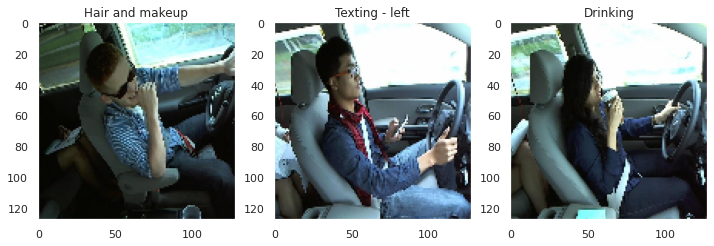

In [9]:
#Visualizing 3 random images from the dataset and their classes
random.seed(10)
sample_idx = random.sample(range(1, len(X_train)),3)

print('Shape of our images: ',np.shape(X_train[sample_idx[0]]))

sns.set_theme(style="dark")
fig, ax = plt.subplots(1,3, figsize=(12,12))
i=0
for idx in sample_idx:
  im = X_train[idx].astype(np.uint8)
  idx_y = np.where(Y_train[idx]==1)[0][0] 
  im_class = class_labels['c'+ str(idx_y)]
  ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  ax[i].set_title(im_class)
  i+= 1
plt.show()

# Deep Learning Models

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Custom Convolution Neural Network

Model Architecture: 

4 bacth normalized convolution layers with relu activation

2 fc connected dense layers

1 softmax layer






### Defining model

In [ ]:
with tf.device('/device:GPU:0'):
  #Building CNN Model
  cnn = CNN(classes = 10)
  cnn.build((None,128,128,3))

  #defining optimizer and loss criterion
  optimizer_cnn = Adam()
  loss_cnn = CategoricalCrossentropy(from_logits=False)
  metric_cnn = ['accuracy']

  cnn.compile(optimizer = optimizer_cnn,
              loss = loss_cnn,
              metrics = metric_cnn)

  print(cnn.summary())


Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  2432      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  51264     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  204928  

### Fitting the model

In [ ]:
with tf.device('/device:GPU:0'):
  #Training the Model
  train_cnn = cnn.fit(x = X_train,
                  y = Y_train,
                  epochs = 15,
                  batch_size = 100,
                  shuffle = True,
                  validation_split = 0.2)

Epoch 1/15
144/144 [==============================] - 13s 74ms/step - loss: 5.1860 - accuracy: 0.2691 - val_loss: 2.0639 - val_accuracy: 0.4342
Epoch 2/15
144/144 [==============================] - 9s 65ms/step - loss: 0.7666 - accuracy: 0.7431 - val_loss: 0.4100 - val_accuracy: 0.8696
Epoch 3/15
144/144 [==============================] - 9s 65ms/step - loss: 0.4109 - accuracy: 0.8639 - val_loss: 0.2236 - val_accuracy: 0.9312
Epoch 4/15
144/144 [==============================] - 9s 66ms/step - loss: 0.2322 - accuracy: 0.9250 - val_loss: 0.1542 - val_accuracy: 0.9468
Epoch 5/15
144/144 [==============================] - 9s 66ms/step - loss: 0.1697 - accuracy: 0.9460 - val_loss: 0.1226 - val_accuracy: 0.9638
Epoch 6/15
144/144 [==============================] - 9s 66ms/step - loss: 0.1276 - accuracy: 0.9601 - val_loss: 0.1507 - val_accuracy: 0.9535
Epoch 7/15
144/144 [==============================] - 9s 66ms/step - loss: 0.1141 - accuracy: 0.9630 - val_loss: 0.0869 - val_accuracy: 0.977

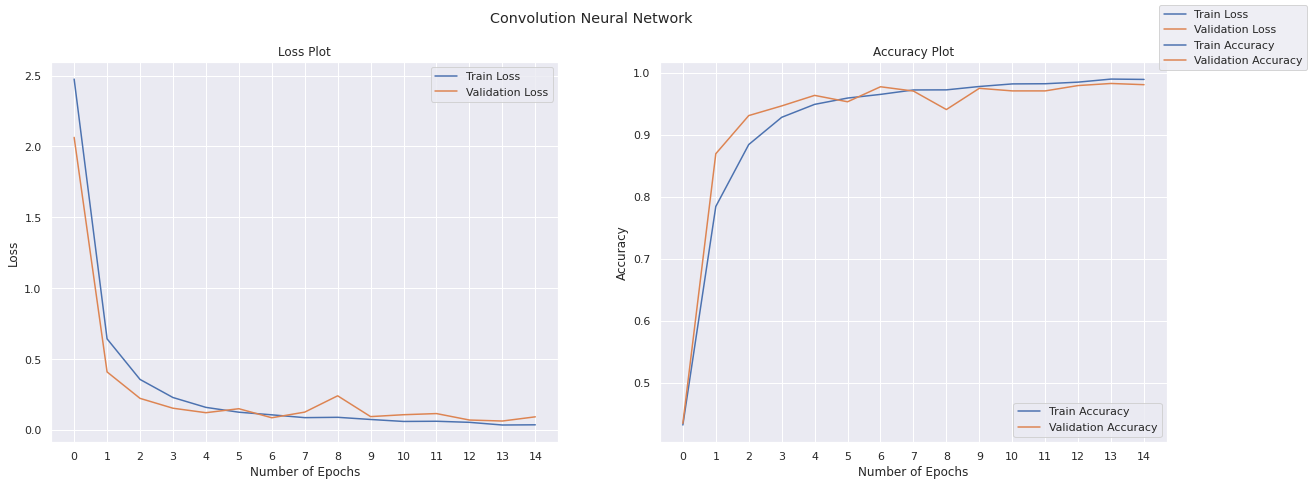

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))
sns.set_theme(style="darkgrid")

sns.lineplot(train_cnn.epoch, train_cnn.history['loss'], label='Train Loss', ax = axs[0])
sns.lineplot(train_cnn.epoch, train_cnn.history['val_loss'], label='Validation Loss', ax = axs[0])
sns.lineplot(train_cnn.epoch, train_cnn.history['accuracy'], label='Train Accuracy', ax = axs[1])
sns.lineplot(train_cnn.epoch, train_cnn.history['val_accuracy'], label='Validation Accuracy', ax = axs[1])
xtick = train_cnn.epoch
fig.suptitle('Convolution Neural Network')
plt.setp(axs[:], xticks=xtick)
axs[0].set_title('Loss Plot')
axs[0].set_ylabel('Loss')
axs[1].set_title('Accuracy Plot')
axs[1].set_ylabel('Accuracy')
plt.setp(axs[:], xlabel='Number of Epochs')
fig.legend()
plt.show()

In [ ]:
#  cnn.save('/content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/cnnModel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/cnnModel/assets


### Loading in the saved Model

In [11]:
cnn_load = tf.keras.models.load_model('/content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/cnnModel')

### Test Accuracy

In [12]:
#Testing Accuracy on text set
cnn_test_pred = cnn_load.predict(X_test)
Y_test_pred_cnn = np.argmax(cnn_test_pred, axis=1) 

cnn_test_accuracy = round(accuracy_score(Y_test, Y_test_pred_cnn)*100,2)
print('CNN Test Accuracy: ', cnn_test_accuracy,'%')

CNN Test Accuracy:  97.57 %


## 2. VGG16


### Defining a VGG16 transfer learning model

In [ ]:
with tf.device('/device:GPU:0'):
  #Building CNN Model
  vgg = vgg16(classes = 10, layers_unfreeze = 2)
  vgg.build((None,128,128,3))

  #defining optimizer and loss criterion
  optimizer_vgg= Adam()
  loss_vgg = CategoricalCrossentropy(from_logits=False)
  metric_vgg = ['accuracy']

  vgg.compile(optimizer = optimizer_vgg,
              loss = loss_vgg,
              metrics = metric_vgg)

  print(vgg.summary())


Model: "vgg16_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_20 (Flatten)         multiple                  0         
_________________________________________________________________
dense_60 (Dense)             multiple                  33558528  
_________________________________________________________________
dense_61 (Dense)             multiple                  4391984   
_________________________________________________________________
dropout_20 (Dropout)         multiple                  0         
_________________________________________________________________
dense_62 (Dense)             multiple                  10730     
Total params: 52,675,930
Trainable params: 40,321,050
Non-trainable params: 12,354,880
______________________________________

### Training the Model

In [ ]:
with tf.device('/device:GPU:0'):
  #Training the Model
  train_vgg = vgg.fit(x = X_train,
                  y = Y_train,
                  epochs = 50,
                  batch_size = 250,
                  shuffle = True,
                  validation_split = 0.2)

Epoch 1/50
58/58 [==============================] - 13s 207ms/step - loss: 48.0475 - accuracy: 0.1444 - val_loss: 2.0769 - val_accuracy: 0.2023
Epoch 2/50
58/58 [==============================] - 11s 196ms/step - loss: 2.0567 - accuracy: 0.2099 - val_loss: 2.0030 - val_accuracy: 0.2336
Epoch 3/50
58/58 [==============================] - 11s 196ms/step - loss: 1.9289 - accuracy: 0.2442 - val_loss: 1.7711 - val_accuracy: 0.2854
Epoch 4/50
58/58 [==============================] - 11s 196ms/step - loss: 1.7279 - accuracy: 0.2999 - val_loss: 1.4575 - val_accuracy: 0.3771
Epoch 5/50
58/58 [==============================] - 11s 196ms/step - loss: 1.3680 - accuracy: 0.4192 - val_loss: 1.1545 - val_accuracy: 0.5195
Epoch 6/50
58/58 [==============================] - 11s 196ms/step - loss: 1.0960 - accuracy: 0.5488 - val_loss: 0.8975 - val_accuracy: 0.6402
Epoch 7/50
58/58 [==============================] - 11s 195ms/step - loss: 0.8626 - accuracy: 0.6537 - val_loss: 0.6642 - val_accuracy: 0.744

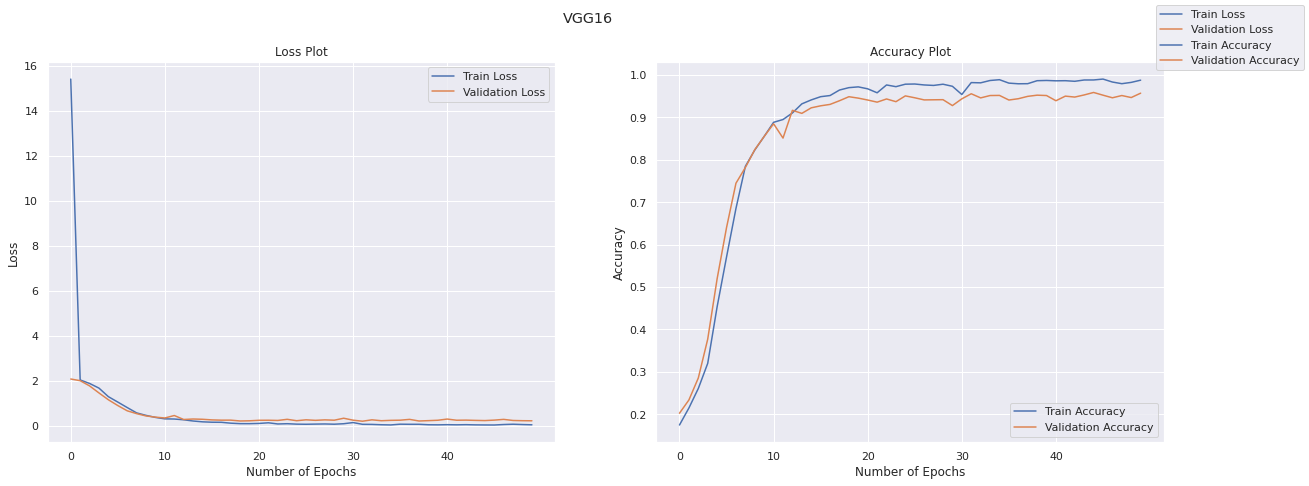

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))

sns.lineplot(train_vgg.epoch, train_vgg.history['loss'], label='Train Loss', ax = axs[0])
sns.lineplot(train_vgg.epoch, train_vgg.history['val_loss'], label='Validation Loss', ax = axs[0])
sns.lineplot(train_vgg.epoch, train_vgg.history['accuracy'], label='Train Accuracy', ax = axs[1])
sns.lineplot(train_vgg.epoch, train_vgg.history['val_accuracy'], label='Validation Accuracy', ax = axs[1])
xtick = [ i for i in train_vgg.epoch if i%10 == 0]
fig.suptitle('VGG16')
plt.setp(axs[:], xticks=xtick)
axs[0].set_title('Loss Plot')
axs[0].set_ylabel('Loss')
axs[1].set_title('Accuracy Plot')
axs[1].set_ylabel('Accuracy')
plt.setp(axs[:], xlabel='Number of Epochs')
fig.legend()
plt.show()

In [ ]:
# vgg.save('/content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/vggModel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/vggModel/assets


###Loading in the tained VGG16 Model

In [13]:
vgg_load = tf.keras.models.load_model('/content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/vggModel')

### Test Set Accuracy

In [14]:
#Testing Accuracy on text set
vgg_test_pred = vgg_load.predict(X_test)
Y_test_pred_vgg = np.argmax(vgg_test_pred, axis=1) 

vgg_test_accuracy = round(accuracy_score(Y_test, Y_test_pred_vgg)*100,2)
print('VGG16 Test Accuracy: ', vgg_test_accuracy,'%')

VGG16 Test Accuracy:  95.76 %


## 3. ResNet50

### Defining a ResNet50 transfer learning model

In [ ]:
with tf.device('/device:GPU:0'):
  #Building CNN Model
  res = resnet50(classes = 10, layers_unfreeze = 20)
  res.build((None,128,128,3))

  #defining optimizer and loss criterion
  optimizer_res= Adam()
  loss_res = CategoricalCrossentropy(from_logits=False)
  metric_res = ['accuracy']

  res.compile(optimizer = optimizer_res,
              loss = loss_res,
              metrics = metric_res)

  print(res.summary())


Model: "resnet50_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten_13 (Flatten)         multiple                  0         
_________________________________________________________________
dense_39 (Dense)             multiple                  134221824 
_________________________________________________________________
dense_40 (Dense)             multiple                  4391984   
_________________________________________________________________
dropout_13 (Dropout)         multiple                  0         
_________________________________________________________________
dense_41 (Dense)             multiple                  10730     
Total params: 162,212,250
Trainable params: 147,555,866
Non-trainable params: 14,656,384
________________________________

### Training the model

In [ ]:
with tf.device('/device:GPU:0'):
  #Training the Model
  train_res= res.fit(x = X_train,
                  y = Y_train,
                  epochs = 5,
                  batch_size = 100,
                  shuffle = True,
                  validation_split = 0.2)

Epoch 1/5
144/144 [==============================] - 21s 118ms/step - loss: 14.1923 - accuracy: 0.5947 - val_loss: 0.1852 - val_accuracy: 0.9459
Epoch 2/5
144/144 [==============================] - 15s 106ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0281 - val_accuracy: 0.9905
Epoch 3/5
144/144 [==============================] - 15s 106ms/step - loss: 0.0135 - accuracy: 0.9949 - val_loss: 0.0307 - val_accuracy: 0.9919
Epoch 4/5
144/144 [==============================] - 15s 106ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0476 - val_accuracy: 0.9875
Epoch 5/5
144/144 [==============================] - 15s 106ms/step - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0448 - val_accuracy: 0.9914


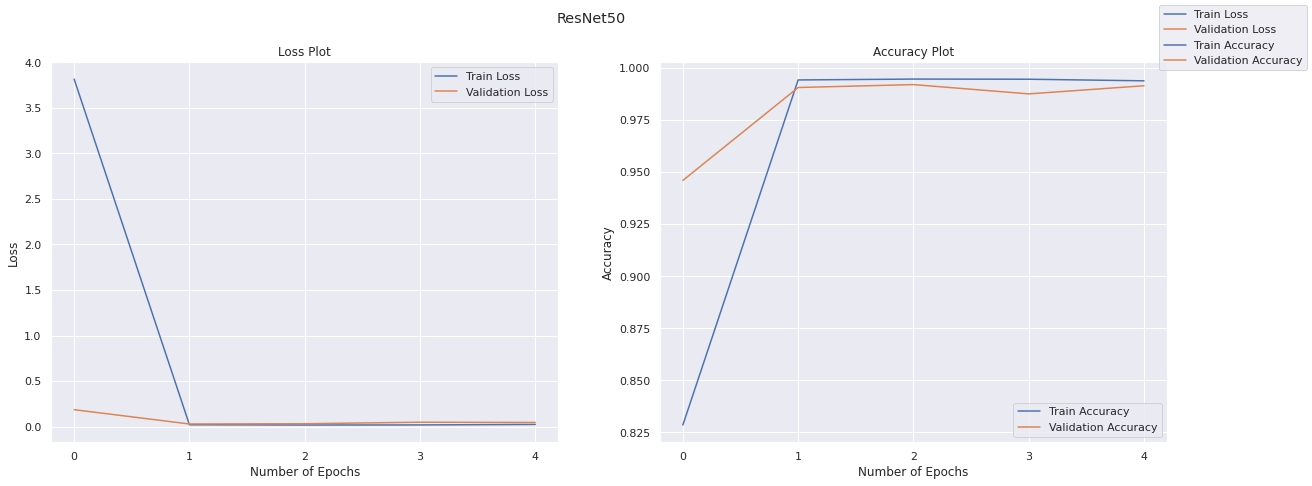

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))

sns.lineplot(train_res.epoch, train_res.history['loss'], label='Train Loss', ax = axs[0])
sns.lineplot(train_res.epoch, train_res.history['val_loss'], label='Validation Loss', ax = axs[0])

sns.lineplot(train_res.epoch, train_res.history['accuracy'], label='Train Accuracy', ax = axs[1])
sns.lineplot(train_res.epoch, train_res.history['val_accuracy'], label='Validation Accuracy', ax = axs[1])
xtick = train_res.epoch
fig.suptitle('ResNet50')
plt.setp(axs[:], xticks=xtick)
axs[0].set_title('Loss Plot')
axs[0].set_ylabel('Loss')
axs[1].set_title('Accuracy Plot')
axs[1].set_ylabel('Accuracy')
plt.setp(axs[:], xlabel='Number of Epochs')
fig.legend()
plt.show()

In [ ]:
# res.save('/content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/resnet50Model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/resnet50Model/assets


### Loading in the saved model

In [15]:
resnet_load = tf.keras.models.load_model('/content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/Keras/resnet50Model')

### Test set Accuracy

In [16]:
#Testing Accuracy on text set
res_test_pred = resnet_load.predict(X_test)
Y_test_pred_res = np.argmax(res_test_pred, axis=1) 

res_test_accuracy = round(accuracy_score(Y_test, Y_test_pred_res)*100,2)
print('ResNet50 Test Accuracy: ', res_test_accuracy,'%')

ResNet50 Test Accuracy:  98.62 %


# Inferences


## Comparing Model Performance

In [ ]:
#creating models dict
models_dict = {'CNN': {'Model': cnn_load, 
                  'History': cnn_load.history},
          'VGG16': {'Model': vgg_load, 
                  'History': vgg_load.history},
          'ResNet50': {'Model': resnet_load, 
                  'History': resnet_load.history}}


In [ ]:
def calc_accuracy( model, x, y):
  pred = model.predict(x)
  y_pred = np.argmax(pred, axis=1)
  return accuracy_score(y, y_pred)

In [ ]:
accuracy_metric = { k:{} for k in ['Train Accuracy', 'Validation Accuracy','Test Accuracy', 'Train Loss','Validation Loss']}

for model in models_dict.keys(): 
  accuracy_metric['Train Accuracy'][model] = np.max(models_dict[model]['History']['accuracy'])
  accuracy_metric['Validation Accuracy'][model] = np.max(models_dict[model]['History'].history['val_accuracy'])
  accuracy_metric['Test Accuracy'][model] = calc_accuracy(models_dict[model]['Model'], X_test, Y_test)
  accuracy_metric['Train Loss'][model] = np.min(models_dict[model]['History'].history['loss'])
  accuracy_metric['Validation Loss'][model] = np.min(models_dict[model]['History'].history['val_loss'])

In [ ]:
accuracy_df = pd.DataFrame(accuracy_metric).T
accuracy_df

,CNN,VGG16,ResNet50
Train Accuracy,0.990105,0.990314,0.994565
Validation Accuracy,0.982999,0.958751,0.991917
Test Accuracy,0.975697,0.957637,0.986176
Train Loss,0.035818,0.033612,0.016866
Validation Loss,0.063872,0.202184,0.028148


On comprison we observe that Resnet50 is the best fitiing model on out data with the Custom CNN and VGG16 models closely following behind.



## Heatmap Visualization

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Get the names of the ten classes
classes = class_labels.keys()

In [18]:
def heatmap(y, y_pred, classes, axis, title):
    conf_mat = confusion_matrix(y, y_pred)
    sns.heatmap(
        conf_mat, 
        annot=True, 
        square=True, 
        xticklabels=classes, 
        yticklabels=classes,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=axis
    )
    axis.set_title(title, fontsize=16)
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45, ha="right")
    axis.set_ylabel('True Label', fontsize=12)
    axis.set_xlabel('Predicted Label', fontsize=12)


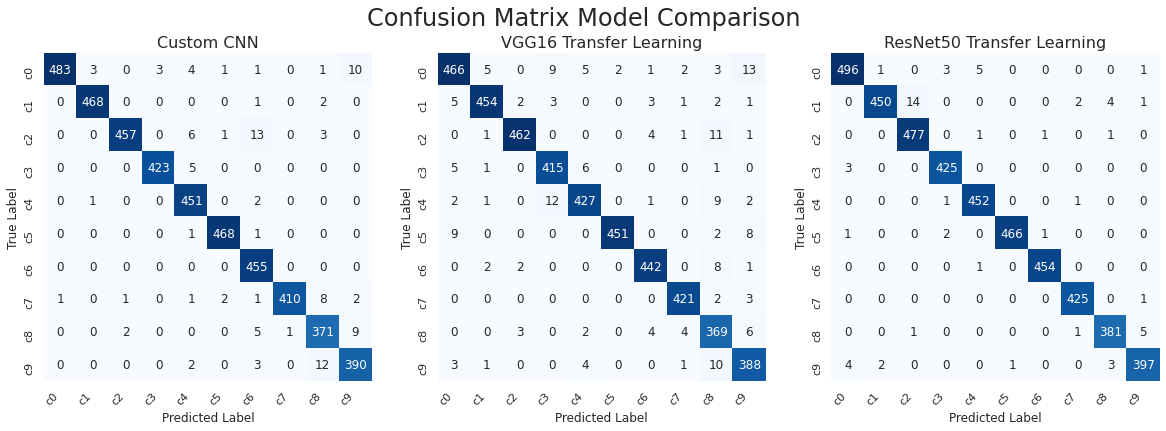

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

heatmap(Y_test, Y_test_pred_cnn, classes, ax1, title="Custom CNN")    
heatmap(Y_test, Y_test_pred_vgg, classes, ax2, title="VGG16 Transfer Learning")    
heatmap(Y_test, Y_test_pred_res, classes, ax3, title="ResNet50 Transfer Learning")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.subplots_adjust(top=1.25)
plt.show()

## Classification Report

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

#function to generate precision, recall and f-1 scores
def generate_scores(y_true, y_pred):
  scores_dict = {'precision': precision_score(y_true, y_pred, average='weighted'), 
                  'recall': recall_score(y_true, y_pred, average='weighted'), 
                  'f1': f1_score(y_true, y_pred, average='weighted')}
  return scores_dict

report = {'CNN':generate_scores(Y_test,Y_test_pred_cnn),
          'VGG16':generate_scores(Y_test,Y_test_pred_vgg),
          'ResNet50':generate_scores(Y_test,Y_test_pred_res)}
report_df = pd.DataFrame(report)
report_df

,CNN,VGG16,ResNet50
precision,0.976310,0.958484,0.986252
recall,0.975697,0.957637,0.986176
f1,0.975747,0.957817,0.986152


In [21]:
#downloading report
pd.to_pickle(report_df, '/content/drive/MyDrive/DS/SML DS 5220/Project/Trained Models/classificationReport.pkl')

## Random Images Prediction Visualization

Shape of our images:  (128, 128, 3)


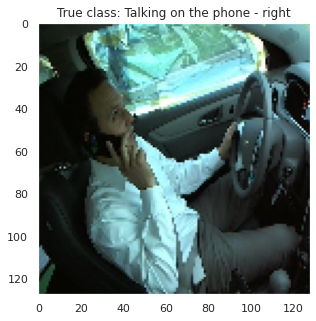

In [22]:
# #Visualizing 3 random images from the dataset and their classes
# random.seed(10)

# #generating random number
# sample_idx = random.randint(1, len(X_test))

# print('Shape of our images: ',np.shape(X_test[sample_idx]))

# sns.set_theme(style="dark")
# plt.figure(figsize=(5,5))

# im = X_test[sample_idx].astype(np.uint8)
# im_class = class_labels['c'+ str(Y_test[sample_idx])]
# plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
# plt.title('True class: ' + im_class)
# plt.show()

Shape of our images:  (128, 128, 3)


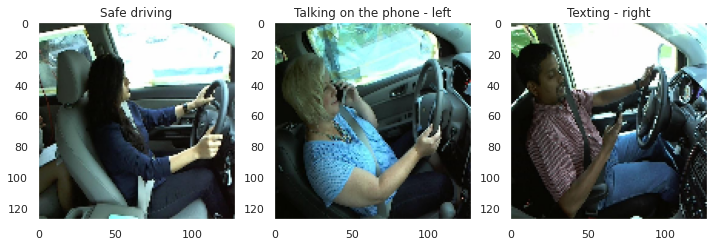

In [56]:
#Visualizing 3 random images from the dataset and their classes
random.seed(42)
sample_idx = random.sample(range(1, len(X_test)),3)

print('Shape of our images: ',np.shape(X_test[sample_idx[0]]))

sns.set_theme(style="dark")
fig, ax = plt.subplots(1,3, figsize=(12,12))
i=0
for idx in sample_idx:
  im = X_test[idx].astype(np.uint8)
  im_class = class_labels['c'+ str(Y_test[idx])]
  ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
  ax[i].set_title(im_class)
  i+= 1
plt.show()

In [55]:
testpred_dict = {'Original': Y_test,
                  'CNN': Y_test_pred_cnn,
                 'VGG16':Y_test_pred_vgg,
                 'ResNet50':Y_test_pred_res}

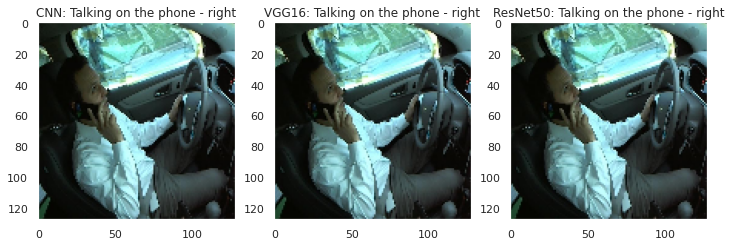

In [24]:
# # predicting the image using all models
# sns.set_theme(style="dark")
# fig, ax = plt.subplots(1,3, figsize=(12,12))
# i=0
# ori_image = X_test[sample_idx].astype(np.uint8) 

# for model_name, testset in testpred_dict.items():
#   im = ori_image
#   im_class = class_labels['c'+ str(testset[sample_idx])]
#   ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
#   ax[i].set_title(model_name+': '+im_class)
#   i+= 1
# plt.show()

Shape of our images:  (128, 128, 3)


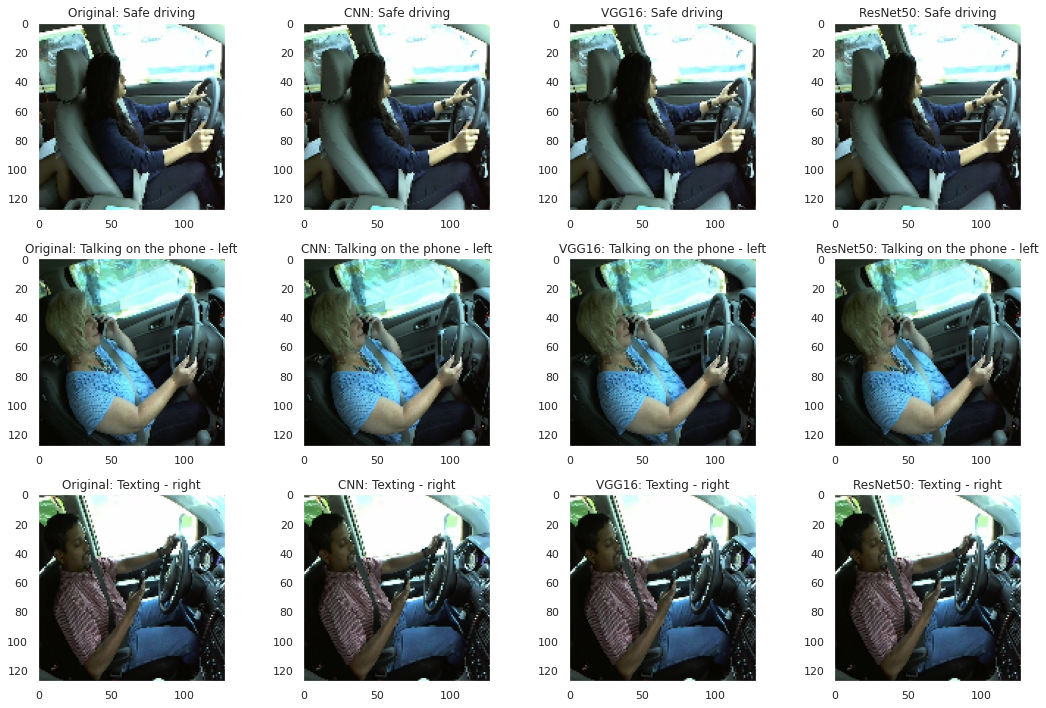

In [69]:
#Visualizing 3 random images from the dataset and their classes
random.seed(42)
sample_idx = random.sample(range(1, len(X_test)),3)

print('Shape of our images: ',np.shape(X_test[sample_idx[0]]))

sns.set_theme(style="dark")
fig, ax = plt.subplots(3,4, figsize=(15,10))
i=0
for idx in sample_idx:
  ori_image = X_test[idx].astype(np.uint8) 
  j=0
  for model_name, testset in testpred_dict.items():
    im = ori_image
    im_class = class_labels['c'+ str(testset[idx])]
    ax[i][j].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax[i][j].set_title(model_name+': '+im_class)
    j+=1
  i+= 1
plt.tight_layout()